# Some descriptive analysis on the "Fragestunden"

## 1: get data for the affairs
We start by querying the database and getting a list of all questions, joined by the info on the authors.

In [1]:
import pg8000
import pandas as pd
%matplotlib inline

Connect to the database

In [2]:
conn = pg8000.connect(database="parl", user="webapp", password="webapp")

Prepare the query - we only want affair_type = '14' and legistative_period = '50'

In [3]:
query = "SELECT affairs.affair_id, affairs.affair_type, affairs.council, affairs.legislative_period, affairs.language, affairs.affair_title, affairs.affair_text, affairs.answer, "
query += "councillors.councillor_id, councillors.firstname, councillors.lastname, councillors.canton, councillors.party "
query += "FROM affairs JOIN councillors ON affairs.councillor_id = councillors.councillor_id "
query += "WHERE affairs.affair_type = '14' AND affairs.legislative_period = '50' "
query += "ORDER BY affairs.affair_id;"
query

"SELECT affairs.affair_id, affairs.affair_type, affairs.council, affairs.legislative_period, affairs.language, affairs.affair_title, affairs.affair_text, affairs.answer, councillors.councillor_id, councillors.firstname, councillors.lastname, councillors.canton, councillors.party FROM affairs JOIN councillors ON affairs.councillor_id = councillors.councillor_id WHERE affairs.affair_type = '14' AND affairs.legislative_period = '50' ORDER BY affairs.affair_id;"

We can use pandas's sql-function to store the query in a DataFrame

In [4]:
df = pd.read_sql(query, conn)

In [5]:
df.head()

,b'affair_id',b'affair_type',b'council',b'legislative_period',b'language',b'affair_title',b'affair_text',b'answer',b'councillor_id',b'firstname',b'lastname',b'canton',b'party'
0,20155540,14,NR,50,de,Prinzip der Wahrung der Interessen der Schweiz...,<p>Die Wahrung der Interessen der Schweiz in d...,,4025,Roland Rino,Büchel,SG,SVP
1,20155541,14,NR,50,de,Lebenslängliche Verwahrung ...,<p>Das Bundesgericht hat erneut eine lebenslän...,,3902,Natalie,Rickli,ZH,SVP
2,20155542,14,NR,50,de,Für eine rasche Umsetzung der Pädophilen-Initi...,<p>Im November wurden verschiedene pädokrimine...,,3902,Natalie,Rickli,ZH,SVP
3,20155543,14,NR,50,de,Schutz des bewaffneten Personals des Bundes ...,<p>Gemäss dem Lagebericht 2015 des Nachrichten...,,4090,Céline,Amaudruz,GE,SVP
4,20155544,14,NR,50,de,Wie kann man nicht schwer vergewaltigen? ...,<p>In seiner Mitteilung vom 30. November 2015 ...,,4090,Céline,Amaudruz,GE,SVP


## 2: get data for the parlamentarians
To have this list separately will be useful for later analysis

In [6]:
query2 = "SELECT councillors.councillor_id, councillors.firstname, councillors.lastname, councillors.canton, councillors.party "
query2 += "FROM councillors;"
query2

'SELECT councillors.councillor_id, councillors.firstname, councillors.lastname, councillors.canton, councillors.party FROM councillors;'

In [7]:
df_c = pd.read_sql(query2, conn)

In [8]:
df_c.head()

,b'councillor_id',b'firstname',b'lastname',b'canton',b'party'
0,4154,Jean-Luc,Addor,VS,SVP
1,3867,Andreas,Aebi,BE,SVP
2,4049,Matthias,Aebischer,BE,SP
3,4053,Thomas,Aeschi,ZG,SVP
4,1131,Evi,Allemann,BE,SP


In [9]:
conn.close()

## 3. Basic description of the dataset

* The **total number of questions** posed during the current legislation is **1022**. This means the adminsitration has to deal with about 500 questions per year (since the current legislature is only two years old) - not bad.

In [10]:
df.shape

(1022, 13)

* on Average, councillors asked 5.1 questions

In [11]:
len(df) / len(df_c)

5.11

* The **language** of all questions is **german** (french was translated - that's handy)

In [95]:
df[b'language'].value_counts()

de    1022
Name: b'language', dtype: int64

## 4: Description by parties

* Here's a list of questions by **party** - it was the **SVP** (rightwing populists) who posed most questions, followed by **SP** (social democrats). Not so surprising, since these parties are the strongest parties in the parliament.

In [141]:
parties_hitlist = df[b'party'].value_counts()
parties_hitlist

SVP             406
SP              243
CVP             108
GPS              98
FDP-Liberale     97
BDP              15
Lega             13
csp-ow           12
glp              12
BastA             8
MCG               4
EVP               4
PdA               2
Name: b'party', dtype: int64

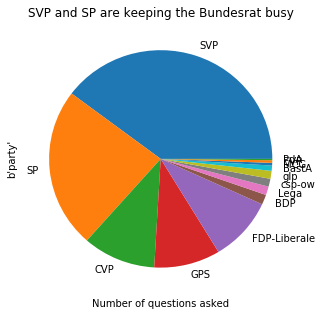

In [142]:
parties_pie = parties_hitlist.plot(kind="pie",figsize=(5,5), title="SVP and SP are keeping the Bundesrat busy")
parties_pie.set_xlabel("Number of questions asked")

* Lets come up with a measure that sets the number of questions asked by each party in in relation to the number of councillors that a party has in the parliament

In [157]:
#The number of parlamentarians for each party
parties_numcounc = df_c[b'party'].value_counts()
#The combined ratio
party_factor = parties_hitlist / parties_numcounc

* We can now see that it is the *small parties* like **CSP** (1 guy from canton Obwalden), **GPS** (the Greens), **BastA** (the leftists) and **Lega** (rightwing-party from Ticino) who ask the most questions per councillor. Seems logical, as councillors from the big parties might have the same questions and no need to ask them twice. On the other side, the format of "Fragestunde" seems to be a popular way for small parties to get themselves heard.

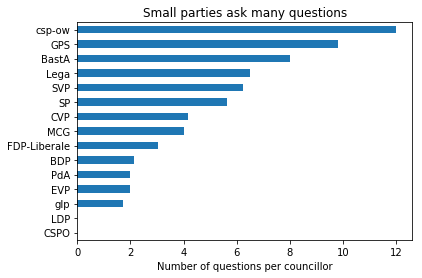

In [156]:
party_factor_plot = party_factor.sort_values(na_position="first").plot(kind="barh")
party_factor_plot.set_title("Small parties ask many questions")
party_factor_plot.set_xlabel("Number of questions per councillor")

## 5: Description by parlamentarians

* And here's the **hitlist of councillors** with the most questions - **Carlo Sommaruga is N. 1**.

* We can also see that **SVP has 4 of the top 10 parlamentarians** and **SP has 3 of the top 10**.

In [105]:
#To start, we construct the full name
df[b'fullname'] = df[b'firstname'] + " " + df[b'lastname'] + ", " + df[b'party']

Carlo Sommaruga, SP                   31
Jean-Luc Addor, SVP                   29
Susanne Leutenegger Oberholzer, SP    27
Céline Amaudruz, SVP                  23
Maximilian Reimann, SVP               23
Claude Béglé, CVP                     22
Claudia Friedl, SP                    18
Fabio Regazzi, CVP                    18
Balthasar Glättli, GPS                18
Manfred Bühler, SVP                   17
Name: b'fullname', dtype: int64

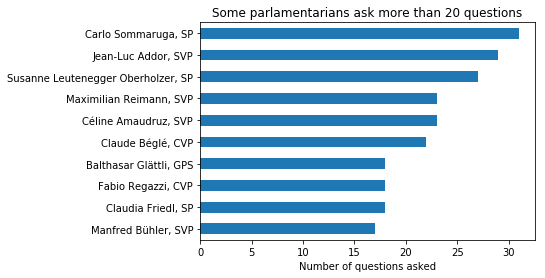

In [167]:
councillors_hitlist = df[b'fullname'].value_counts()
councillors_hitlist_plot = councillors_hitlist.head(10).sort_values().plot(kind="barh")
councillors_hitlist_plot.set_title("Some parlamentarians ask more than 20 questions")
councillors_hitlist_plot.set_xlabel("Number of questions asked")

* Let's see what **Carlo Sommaruga** is concerned with: Lots of foreign policy questions (especially middle east), some on social security

In [172]:
pd.set_option("max_colwidth", 200)
df[df[b'fullname'] == "Carlo Sommaruga, SP"][b'affair_title']

27      Schutz der Konsumentinnen und Konsumenten. Produkte aus den von Israel besetzten palästinensischen Gebieten                                                                                         ...
28      Auslandschweizerinnen und -schweizer. Beitragszahlungen an die Schweizerische Ausgleichskasse sind für Schweizerinnen und Schweizer in Argentinien nicht möglich                                    ...
71      Neuverhandlung des Freihandelsabkommens mit Mexiko in Aussicht?                                                                                                                                     ...
72      Iran. Todesstrafe und Antidrogenprogramm des UNODC                                                                                                                                                  ...
90      AIIB. Perspektiven für den Schweizer Finanzplatz                                                                                                                

In [177]:
df.loc[1018, b'affair_text']

'<p>Das Schweizer Konsulat in Algier hat acht algerischen Gewerkschaftern, die die unabhängige Gewerkschaftsbewegung vertreten, die Visa verweigert. Dadurch hat die Schweiz die Gewerkschaftsbewegung daran gehindert, sich an der aktuell stattfindenden Konferenz der Internationalen Arbeitsorganisation in Genf energisch für die Koalitionsfreiheit in Algerien auszusprechen.</p><p>- Wie rechtfertigt der Bundesrat diese Entscheidung?</p><p>- Besteht nicht die Gefahr, dass der Ruf der Schweiz und des internationalen Genf durch diese Entscheidung geschädigt wird?</p>'

## 6: Description by cantons

* Not surprisingly, most questions are asked by councillors from **Zurich** and **Berne** (these are the biggest cantons with the most representatives)

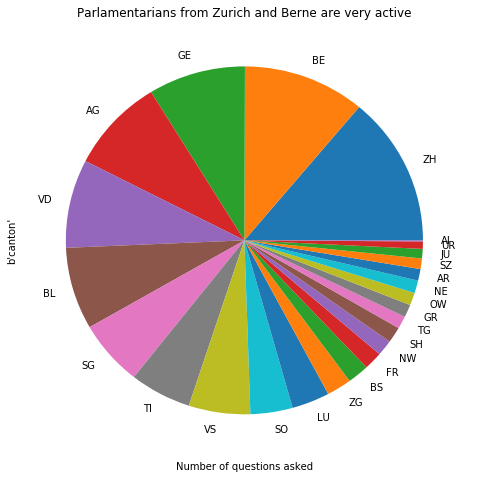

In [159]:
cantons_hitlist = df[b'canton'].value_counts()
cantons_pie = cantons_hitlist.plot(kind="pie", figsize=(8,8))
cantons_pie.set_title("Parlamentarians from Zurich and Berne are very active")
cantons_pie.set_xlabel("Number of questions asked")

* We will now also put this number in context by giving the number of councillors for each canton

In [161]:
#the nuber of councillors per canton
cantons_numcounc = df_c[b'canton'].value_counts()
#the combined ratio
cantons_factor = cantons_hitlist / cantons_numcounc

* Zurich and Berne are now somewhere in the middle. Apart from **Obwalden** (where we had the CSP-guy) we also have **Nidwalden** (the neighbor canton) on top - seems like these two mountain-cantons have many questions. Apart from that, there is no clear regional pattern (like urban-rural, french-german or so)

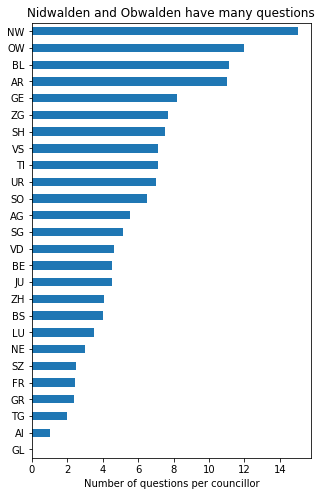

In [166]:
cantons_factor_plot = cantons_factor.sort_values(na_position="first").plot(kind="barh", figsize=(5,8))
cantons_factor_plot.set_title("Nidwalden and Obwalden have many questions")
cantons_factor_plot.set_xlabel("Number of questions per councillor")